In [5]:
from math import floor
import math 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [6]:
''''Recorte de la imagen por cada uno de las capas de laimagen, el recorte se hace al obtener los puntosmas luminosos de ancho  largo'''
def recorte(imagen,umbral):
    #umbral = thresholdOtsu(np.array(imagen))
    minAncho = 1000
    maxAncho = 0
    minAlto = 1000
    maxAlto = 0
    '''Se trata de evitar que se tomen puntos que se enencuetren fuera del cerebro'''
    limite = int(umbral *1.05)
    print(limite)
    for i in range(0, imagen.shape[0]):
        for j in range(0, imagen.shape[1]):
            if np.all((imagen[i][j] >= umbral) & (limite>=imagen[i][j]) ):
                if(i < minAncho):
                    minAncho = i
                if(i > maxAncho):
                    maxAncho = i
                if(j < minAlto):
                    minAlto = j
                if(j > maxAlto):
                    maxAlto = j

    #recortamos la imagen
    imagen = imagen[minAncho:maxAncho, minAlto:maxAlto]

    return imagen 

'''Es la misma función pero en este caso el recorte se hace para imagenes en escala de grises'''
def recorteGris(imagen,umbral):
    #umbral = thresholdOtsu(np.array(imagen))
    minAncho = 1000
    maxAncho = 0
    minAlto = 1000
    maxAlto = 0
    limite = int(umbral *1.05)
    for i in range(0, imagen.shape[0]):
        for j in range(0, imagen.shape[1]):
            if  np.all((imagen[i][j] >= umbral) & (limite>=imagen[i][j])  ):
                if(i < minAncho):
                    minAncho = i
                if(i > maxAncho):
                    maxAncho = i
                if(j < minAlto):
                    minAlto = j
                if(j > maxAlto):
                    maxAlto = j

    #recortamos la imagen
    imagen = imagen[minAncho:maxAncho, minAlto:maxAlto]

    return imagen 

In [7]:
#Funcion de interpolacion bilineal (imagen, ancho, alto)
def BiLinear_interpolation(img,dstH,dstW):
    
    #Crea el arreglo con las dimensiones dadas
    scrH,scrW,_=img.shape 
    #print(img.shape)
    img=np.pad(img,((0,1),(0,1),(0,0)),'constant')
    
    #Llenar la matriz de 0's
    retimg=np.zeros((dstH,dstW,3),dtype=np.uint8)
    
    #Recorrido en ancho y alto 
    for i in range(dstH):
        for j in range(dstW):
            
            #Interpolacion en X
            scrx=(i+1)*(scrH/dstH)-1
            
            #Interpolacion en Y
            scry=(j+1)*(scrW/dstW)-1
            
            #Funcion piso
            x=math.floor(scrx)
            y=math.floor(scry)
            
            #Asignacion de los valores con funcion piso
            u=scrx-x
            v=scry-y
            
            #Llenar los valores de la nueva imagen redimensionada con el recorrido de for anidados
            retimg[i,j]=(1-u)*(1-v)*img[x,y]+u*(1-v)*img[x+1,y]+(1-u)*v*img[x,y+1]+u*v*img[x+1,y+1]
    return retimg

#Llamado de funcion al doble de tamaño
#image2=BiLinear_interpolation(image,500,500)

#Conversion a imagen
#image2=Image.fromarray(image2.astype('uint8')).convert('RGB')

#Guardar la imagen
#image2.save('BILINEAL.png')

In [8]:
def hitograma(imagen):
    hist = np.zeros(256, dtype=np.uint8)
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            hist[imagen[i, j]] += 1
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    # Mostrar la imagen en el primer subgráfico
    axs[0].imshow(imagen, cmap='gray')
    axs[0].set_title("Imagen")

    # Mostrar el histograma en el segundo subgráfico
    axs[1].stem(hist)
    axs[1].set_title("Histograma")

    # Mostrar la figura
    plt.show()



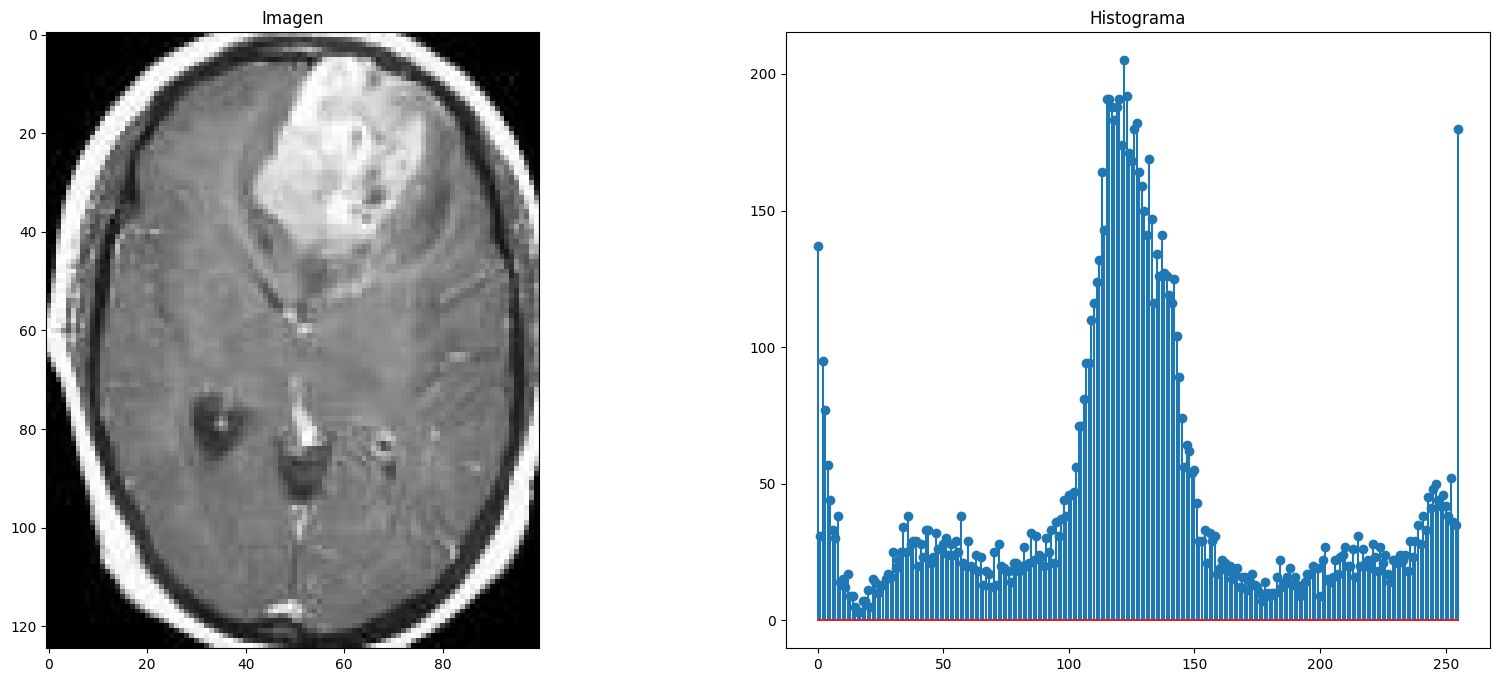

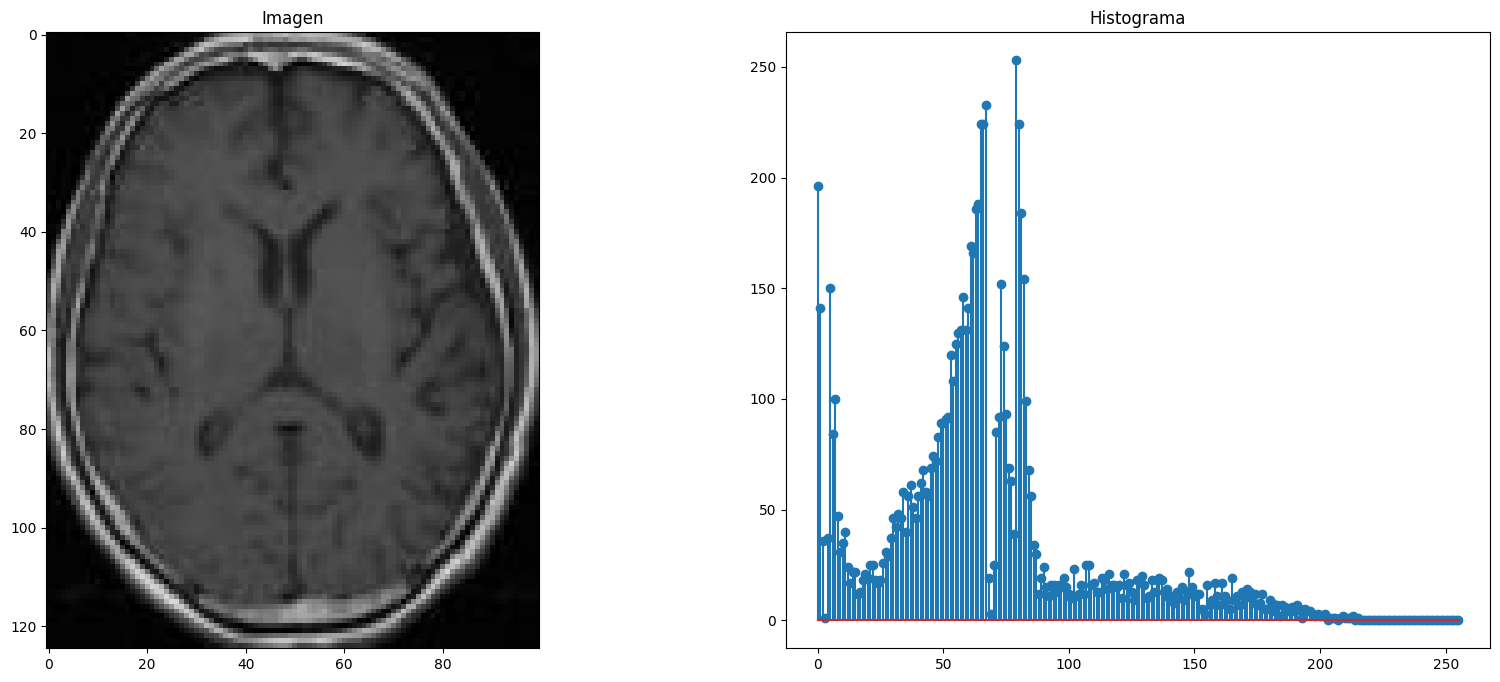

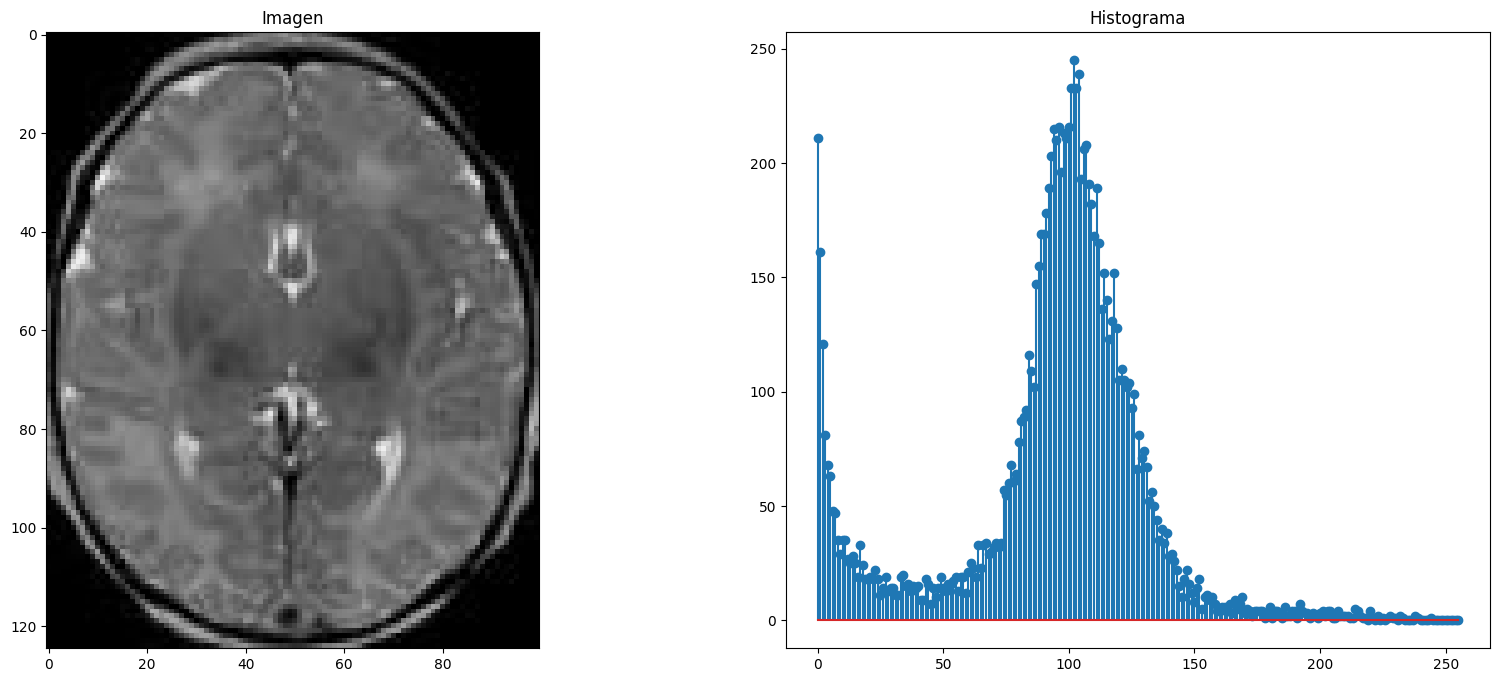

"Se geenra un archivo tipo .txt en donde se almacenana los pixeles de la imagen que se encuentra en escala de grises\npara ello se obtienen el maximo de los trescanales que reresentan a la imagen\nnombre_archivo = 'matriz.txt'\nwith open(nombre_archivo, 'w') as archivo:\n    for fila in image2:\n        linea = ' '.join(str(max(elemento)) for elemento in fila) + '\n'\n        archivo.write(linea)"

In [16]:
imagen = Image.open("yes_nuevo/Y169.jpg")
imagen2 = Image.open("no_nuevo/N5.jpg")
imagen3 = Image.open("no_nuevo/N43.jpg")

hitograma(np.array(imagen))
hitograma(np.array(imagen3))
hitograma(np.array(imagen2))



#print(hist)


'''Se geenra un archivo tipo .txt en donde se almacenana los pixeles de la imagen que se encuentra en escala de grises
para ello se obtienen el maximo de los trescanales que reresentan a la imagen
nombre_archivo = 'matriz.txt'
with open(nombre_archivo, 'w') as archivo:
    for fila in image2:
        linea = ' '.join(str(max(elemento)) for elemento in fila) + '\n'
        archivo.write(linea)'''




In [10]:
# Ruta de la carpeta que contiene las imágenes
def abrirArchivo():
    ruta_carpeta = 'C:\ProyectoImgIa\ProyectoFinalTumor\yes'

    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir(ruta_carpeta)

    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
        # Comprobar si el archivo es una imagen
        if archivo.endswith('.jpg') :
            # Ruta completa de la imagen
            ruta_imagen = os.path.join('yes/', archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_imagen)
            print(ruta_imagen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            #imagen = recorte(np.array(imagen), thresholdOtsuGris(np.array(imagen))).astype(np.uint8)
            imagen = recorte(np.array(imagen),120)
            image2 = BiLinear_interpolation(imagen,250,200)
            plt.imshow(image2,cmap="gray")
            plt.show()

            # Realizar operaciones con la imagen


            # Por ejemplo, mostrar la imagen
            #imagen.show()
            del image2
            # Cerrar la imagen
            #imagen.close()

#abrirArchivo()

In [18]:

def abrirArchivo():
    carpeta_destino = 'C:\\ProyectoImgIa\\ProyectoFinalTumor\\no_nuevo'
    dir_to_search = 'C:\\ProyectoImgIa\\ProyectoFinalTumor\\no'
    archivos = os.listdir(dir_to_search)
    # print(archivos)

    # Crear la carpeta de destino si no existe
    os.makedirs(carpeta_destino, exist_ok=True)
    
    contador = 1

    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
    # Comprobar si el archivo es una imagen
            contador += 1
            #print(archivo)
            # Ruta completa del archivo de origen
            ruta_archivo_origen = os.path.join(dir_to_search, archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_archivo_origen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            #imagen = recorte(np.array(imagen), thresholdOtsuGris(np.array(imagen))).astype(np.uint8)
            imagen = recorte(np.array(imagen),120)
            image2 = BiLinear_interpolation(imagen, 125, 100)

            # Generar el nombre único del archivo destino
            #nombre_archivo_destino = f'N{contador}'
            nombre_archivo_destino = 'N' + str(contador) + '.jpg'
            #print(nombre_archivo_destino)
            

            # Generar la ruta completa para guardar la imagen en la carpeta destino
            ruta_archivo_destino = os.path.join(carpeta_destino, nombre_archivo_destino)

            # Guardar la imagen en la carpeta destino
            plt.imsave(ruta_archivo_destino, image2, cmap='gray')

            # Cerrar la imagen original
            #imagen.close()
            del imagen
            del image2
        
            
    print(contador)


#abrirArchivo()


In [17]:
from PIL import Image

# Carga la imagen
imagen = Image.open('yes/Y1.jpg')

# Redimensiona la imagen
nuevo_ancho = 100
nuevo_alto = 125
imagen_redimensionada = imagen.resize((nuevo_ancho, nuevo_alto))

# Guarda la imagen redimensionada
imagen_redimensionada.save('fondoP.jpg')